# 1083 Albumin Initial ML

### By: Ian Weimer

In [1]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.7.0


In [2]:
#print("Imbalanced-Learn", imbalanced-learn.__version__)

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [4]:
df = pd.read_csv('N04_matched_1.csv')

In [5]:
df.CCI.value_counts()

0     882
4     418
2     365
5     362
3     323
1     239
6     218
7     137
8      90
9      52
10     28
11     10
12      6
13      5
14      4
18      1
Name: CCI, dtype: int64

In [6]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [7]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   diuretic  propensity_score  propensity_logit  albumin_24hrs  \
0         1          0.771511          1.216863              1   
1         1          0.551220          0.205600              1   
2         1          0.910373          2.318201              1   
3         1          0.788312          1.314781              1   
4         1          0.727234          0.980636              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [8]:
df.shape

(3140, 17)

In [9]:
df.propensity_logit.describe()

count    3140.000000
mean        0.698976
std         0.932335
min        -2.634775
25%         0.126117
50%         0.707470
75%         1.240499
max         3.578548
Name: propensity_logit, dtype: float64

## Add ICU-variable based dataframes

### ICU Cohort

### Non ICU Cohort

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [10]:
m_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_mortality'].value_counts()
print(m_90d_a24)

0    1454
1     116
Name: 90_day_mortality, dtype: int64


In [11]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(m_90d_a24)

7.388535031847134

In [12]:
m_90d = df[df['albumin_24hrs'] == 0]['90_day_mortality'].value_counts()
print(m_90d)

0    1496
1      74
Name: 90_day_mortality, dtype: int64


In [13]:
binary_pct(m_90d)

4.713375796178345

In [14]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   diuretic  propensity_score  propensity_logit  albumin_24hrs  \
0         1          0.771511          1.216863              1   
1         1          0.551220          0.205600              1   
2         1          0.910373          2.318201              1   
3         1          0.788312          1.314781              1   
4         1          0.727234          0.980636              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [15]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit', 'albumin', 'albumin_timing'], inplace=True)

In [16]:
df.drop(columns=['90_day_readmission', 'LOS_days', 'hospital_free_days'], inplace=True)

In [17]:
# df.drop(columns=['MELD'], inplace=True)

In [18]:
df.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  diuretic  albumin_24hrs  90_day_mortality
0    0          0    0      1     2         1              1                 0
1    0          0    1      0     0         1              1                 0
2    0          1    0      1     2         1              1                 0
3    0          0    0      1     3         1              1                 0
4    0          0    4      1     3         1              1                 0

In [19]:
# remove non-baseline variables

# df.drop(columns=['beta_blocker', 'bl_albumin_value', 'SAPS', 'qSOFA'], inplace=True)

In [20]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  3140.000000  3140.000000  3140.000000  3140.000000  3140.000000   
mean      0.114650     0.228662     3.017834     0.447134     1.208280   
std       0.318649     0.420038     2.713165     0.592570     1.518683   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     0.000000     1.000000   
75%       0.000000     0.000000     5.000000     1.000000     2.000000   
max       1.000000     1.000000    18.000000     3.000000     9.000000   

          diuretic  albumin_24hrs  90_day_mortality  
count  3140.000000     3140.00000       3140.000000  
mean      0.935032        0.50000          0.060510  
std       0.246509        0.50008          0.238466  
min       0.000000        0.00000          0.000000  
25%       1.000000        0.00000          0.000000  
50%       1.000000        0.50000          0.000000  
75%       1.000000        1.00000          0.000000  
max       1.000000        1.00000          1.000000

In [21]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

In [22]:
df['90_day_mortality'].value_counts()

0    2950
1     190
Name: 90_day_mortality, dtype: int64

In [23]:
# df[df['albumin_24hrs'] == 1]['MELD'].describe()

In [24]:
# df[df['albumin_24hrs'] == 0]['MELD'].describe()

In [25]:
df[df['albumin_24hrs'] == 1]['CCI'].describe()

count    1570.000000
mean        2.669427
std         2.846781
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        14.000000
Name: CCI, dtype: float64

In [26]:
df[df['albumin_24hrs'] == 0]['CCI'].describe()

count    1570.000000
mean        3.366242
std         2.525890
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        18.000000
Name: CCI, dtype: float64

In [29]:
df[df['albumin_24hrs'] == 1]['qSOFA'].value_counts()

0    948
1    557
2     65
Name: qSOFA, dtype: int64

In [30]:
df[df['albumin_24hrs'] == 0]['qSOFA'].value_counts()

0    949
1    527
2     92
3      2
Name: qSOFA, dtype: int64

## Modeling

In [27]:
# establish target feature, LOS_days, as y feature
y = df['90_day_mortality']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_mortality'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [28]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'diuretic',
       'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [29]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [30]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  diuretic  albumin_24hrs
0    0          0    0      1     2         1              1
1    0          0    1      0     0         1              1
2    0          1    0      1     2         1              1
3    0          0    0      1     3         1              1
4    0          0    4      1     3         1              1

In [31]:
X.shape

(3140, 7)

In [32]:
X.SEWS.describe()

count    3140.000000
mean        1.208280
std         1.518683
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: SEWS, dtype: float64

## Train Test Split

In [33]:
#sm = SMOTENC(random_state=42, categorical_features = [0, 1, 2, 3, \
#                                                     6])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [34]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, 5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [35]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [36]:
# what tree uses in flowchart

y_train.value_counts()

0    2360
1    2360
Name: 90_day_mortality, dtype: int64

In [37]:
X_train.albumin_24hrs.value_counts()

0    2458
1    2262
Name: albumin_24hrs, dtype: int64

In [38]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [39]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.26121
Feature: Cirrhosis Score: -0.30482
Feature: CCI Score: 0.15483
Feature: qSOFA Score: 0.14204
Feature: SEWS Score: 0.05020
Feature: diuretic Score: 0.62796
Feature: albumin_24hrs Score: 0.01837


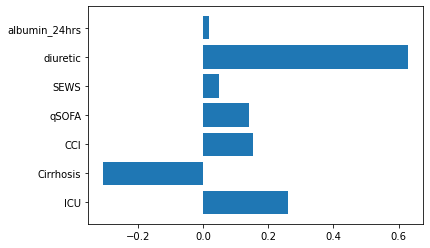

In [40]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
diuretic         1.873790
ICU              1.298506
CCI              1.167459
qSOFA            1.152622
SEWS             1.051480
albumin_24hrs    1.018537
Cirrhosis        0.737255


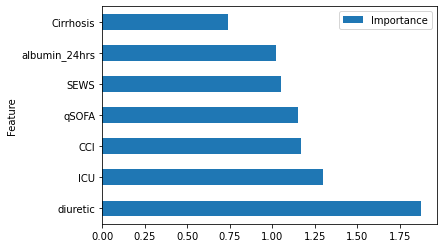

In [41]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [42]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [43]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1583  777]
 [ 696 1664]]


In [44]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2360
           1       0.68      0.71      0.69      2360

    accuracy                           0.69      4720
   macro avg       0.69      0.69      0.69      4720
weighted avg       0.69      0.69      0.69      4720



In [45]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[392 198]
 [ 13  25]]


In [46]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       590
           1       0.11      0.66      0.19        38

    accuracy                           0.66       628
   macro avg       0.54      0.66      0.49       628
weighted avg       0.92      0.66      0.75       628



## 1: Decision Tree 

In [47]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.07262
Feature: Cirrhosis Score: 0.07383
Feature: CCI Score: 0.64430
Feature: qSOFA Score: 0.08918
Feature: SEWS Score: 0.06317
Feature: diuretic Score: 0.00000
Feature: albumin_24hrs Score: 0.05691


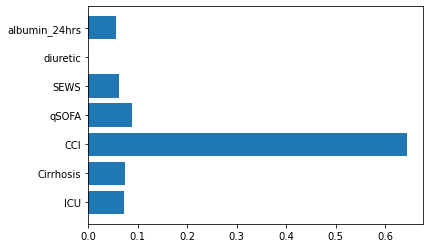

In [48]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [49]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [50]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1718  642]
 [ 639 1721]]


In [51]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2360
           1       0.73      0.73      0.73      2360

    accuracy                           0.73      4720
   macro avg       0.73      0.73      0.73      4720
weighted avg       0.73      0.73      0.73      4720



In [52]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[423 167]
 [ 16  22]]


In [53]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       590
           1       0.12      0.58      0.19        38

    accuracy                           0.71       628
   macro avg       0.54      0.65      0.51       628
weighted avg       0.91      0.71      0.78       628



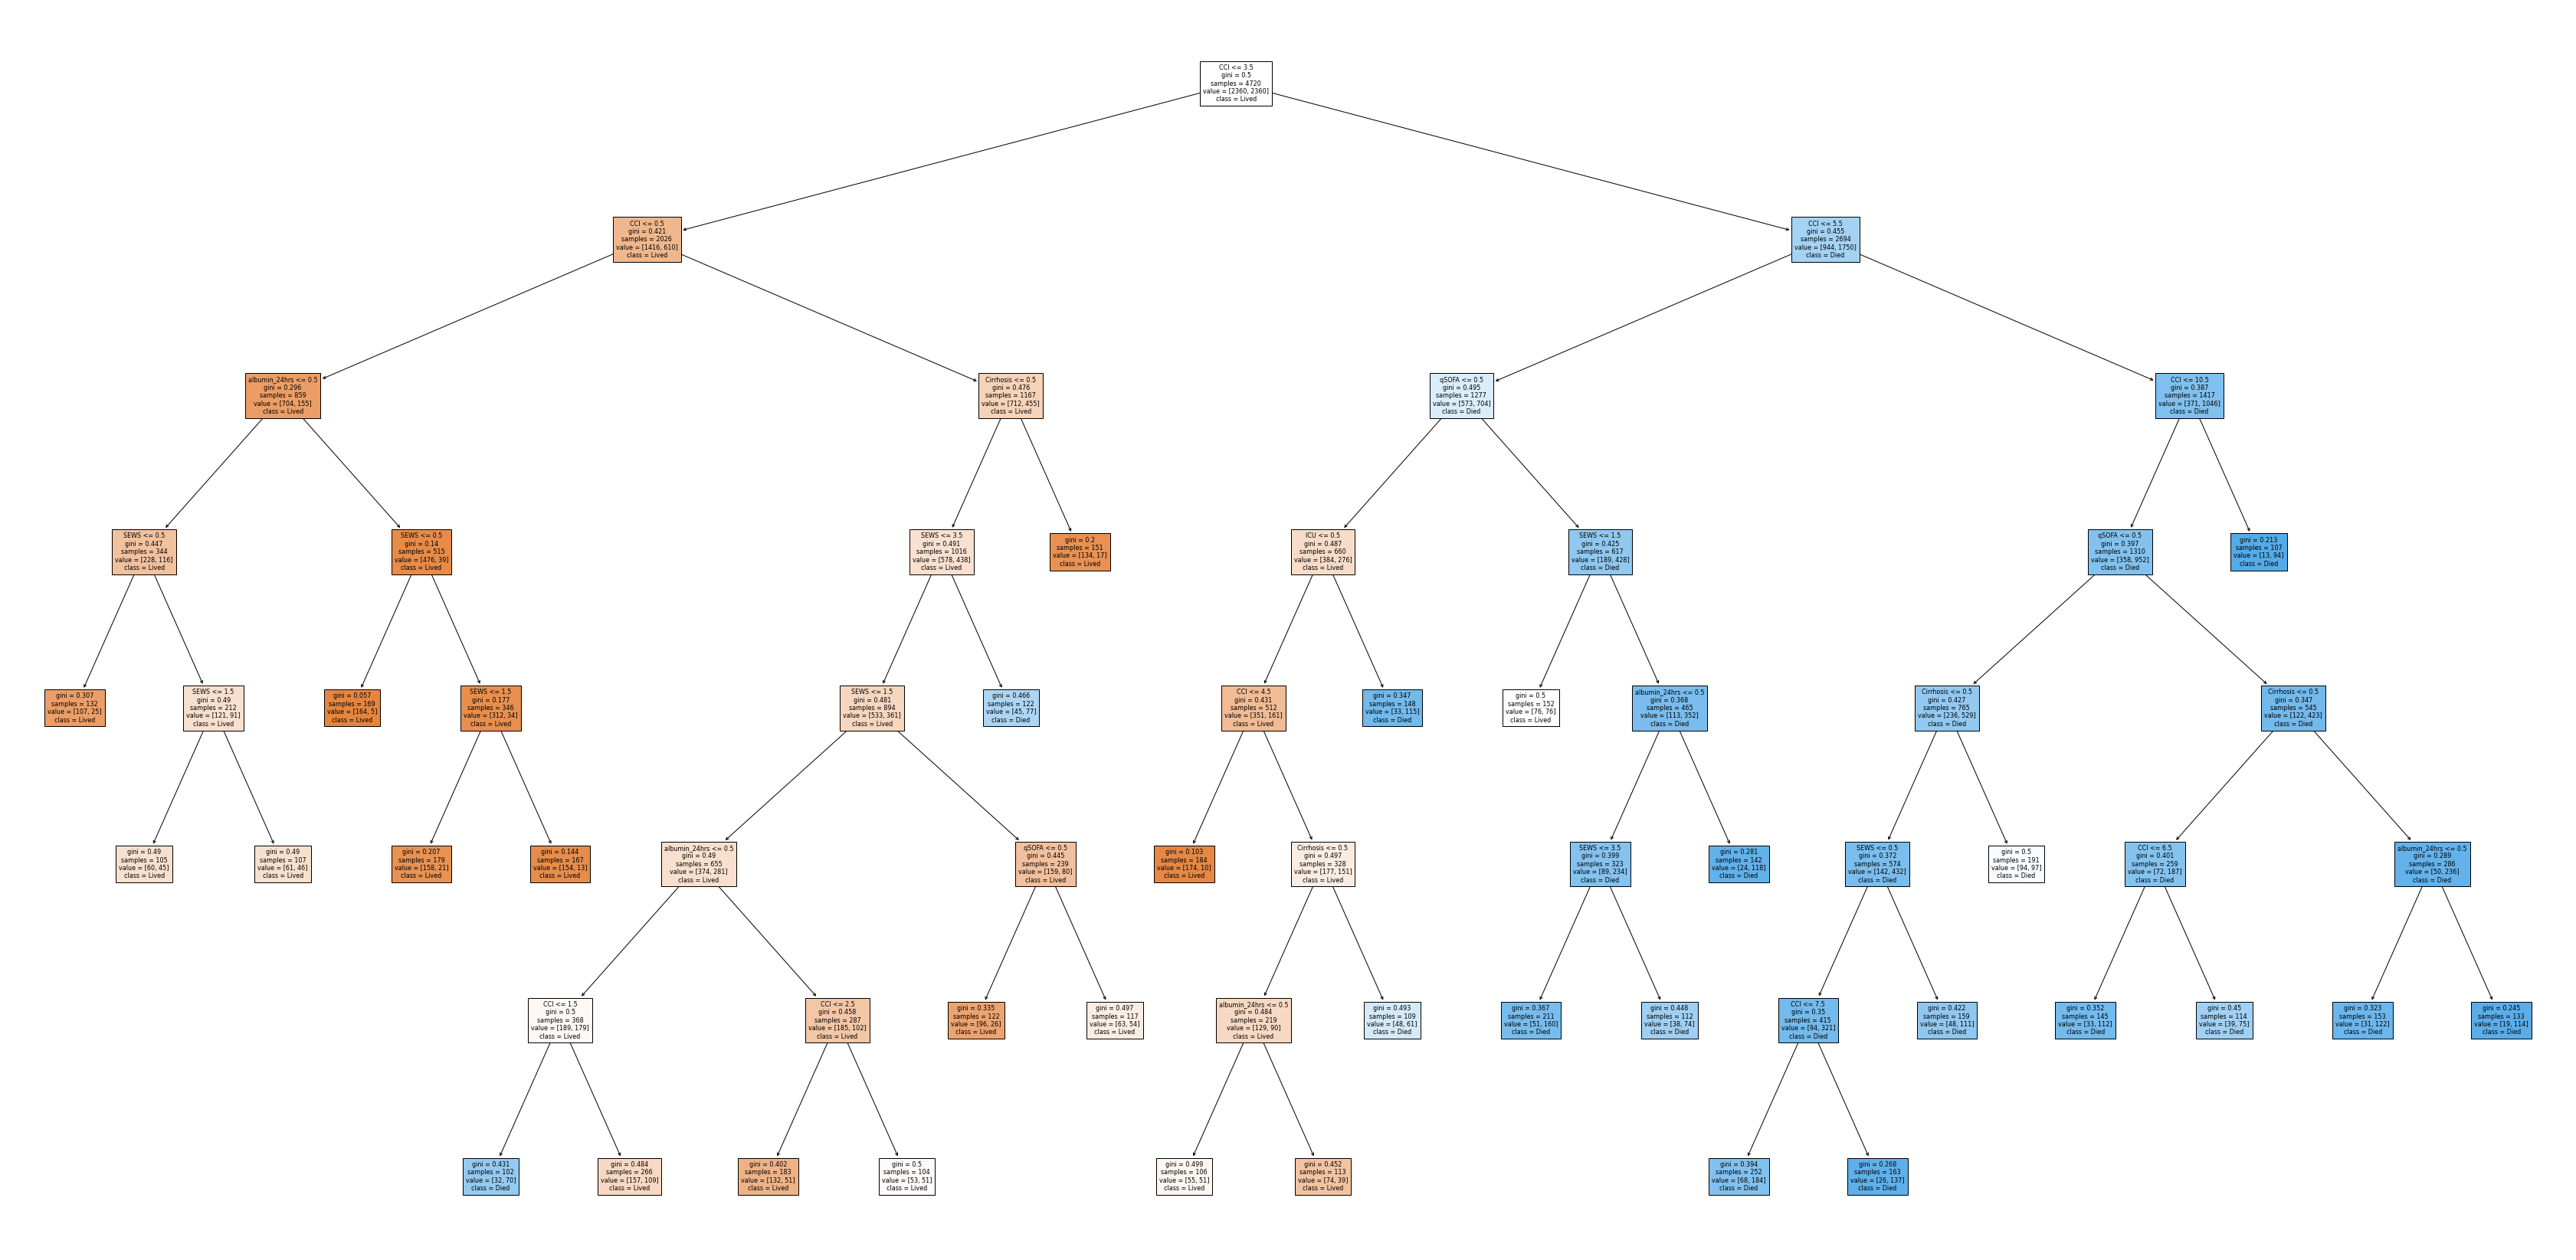

In [54]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [55]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DM_DT_D7_PSM_MATCHED_1.png')

True

## Random Forest

In [56]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [57]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [58]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1719  641]
 [ 623 1737]]


In [59]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2360
           1       0.73      0.74      0.73      2360

    accuracy                           0.73      4720
   macro avg       0.73      0.73      0.73      4720
weighted avg       0.73      0.73      0.73      4720



In [60]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[417 173]
 [ 12  26]]


In [61]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       590
           1       0.13      0.68      0.22        38

    accuracy                           0.71       628
   macro avg       0.55      0.70      0.52       628
weighted avg       0.92      0.71      0.78       628



Feature: ICU Score: 0.05905
Feature: Cirrhosis Score: 0.02164
Feature: CCI Score: 0.73903
Feature: qSOFA Score: 0.04598
Feature: SEWS Score: 0.08279
Feature: diuretic Score: 0.02064
Feature: albumin_24hrs Score: 0.03087


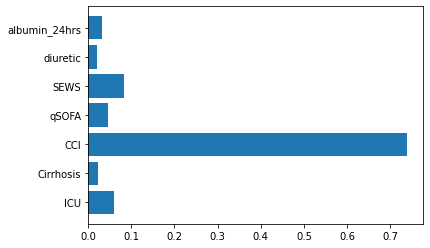

In [62]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()